# Daten der Bundesnetzagentur und ein paar Auswertungen

Die Bundesnetzagentur bietet zahlreiche "Energiedaten" über eine API-Schnittstelle an, siehe: https://www.smard.de/home. Insbesondere die in den letzten Jahren stark schwankenden Tarife lohnen einen genaueren Blick. Wir analysieren hier die Stundenpreise, die jeweils am frühen Nachmittag für den Folgetag zur Verfügung gestellt werden. Diese Daten zeigen einige sehr interessante Zusammenhänge. Für "smarte" Energiesysteme (z.B. Wärmepumpen, PV-Speicher,...) ergeben sich hohe Potentiale zur Kostenoptimierung und damit verbunden eine netzdienliche Mitwirkung zur Einbindung fluktuierender Energieerzeuger.
Zunächst werden einige hilfreiche Unterroutinen definiert.

In [1]:
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
# Functions to convert timestamps

def get_last_monday_of_day(date_time):
    days_to_subtract = date_time.weekday()
    result_time = date_time - datetime.timedelta(days=days_to_subtract)
    t = datetime.time(0, 0)
    return datetime.datetime.combine(result_time,t)
def get_start_time_of_day(date_time):
    result_time = datetime.datetime(year=date_time.year, month=date_time.month, day=date_time.day) # 00:00
    return result_time
def get_time_string_last_monday(date_str=None):
    if date_str == None:
        date = datetime.date.today()
    else:
        date = datetime.datetime.strptime(date_str, '%d.%m.%Y').date()
    return str(int(1000*get_last_monday_of_day(date).timestamp()))


In [12]:
# A function to plot two graphs over time
def plot_hourly_forecast(time_ticks, graph_1, graph_2, 
                         headline='German hourly day-ahead electricity prices',
                         colors=['black','black'],
                         y_labels=['ct/kWh (netto)', 'ct/kWh (brutto)'],
                         labels=['','']):
    color_1  = colors[0]
    ylabel_1 = y_labels[0]
    color_2  = colors[1]
    ylabel_2 = y_labels[1]
    fig, ax1 = plt.subplots(1, 1,figsize=(18,5))
    ax1.set_title(headline+time_ticks[0].strftime("%d. %b %Y, %H:%M to ")+
                  time_ticks[-1].strftime("%d. %b, %H:%M"), fontweight ="bold")
    ax1.plot(time_ticks, graph_1, color_1, drawstyle='steps-post', label=labels[0])
    ax1.set_xlabel('day/hour')
    ax1.set_ylabel(ylabel_1)
    ax1.grid()
    ax1.tick_params(axis='y', colors=color_1)
    ax1.yaxis.label.set_color(color_1)
    ax1.xaxis.label.set_color('black')
    if y_labels[1]==None:
        ax1.plot(time_ticks, graph_2, color_2, drawstyle='steps-post', label=labels[1])
        ax1.legend()
    else:
        ax2 = ax1.twinx()
        ax2.plot(time_ticks, graph_2, color_2, drawstyle='steps-post', label=labels[1]) 
        ax2.set_ylabel(ylabel_2);
        ax2.tick_params(axis='y', colors=color_2)
        ax2.yaxis.label.set_color(color_2)
    return fig, ax1

#plot_hourly_forecast(x,np.array(y)/10, (1.19*np.array(y)/10)+13.036)

In [4]:
# Function to download time series over one week periode for a specific dataset.
# Note: The sequence starts always on Monday 00:00. It typically has 168 values, 
# except for the current week that may not yet be finished.
def get_time_sequence(filter_str, date_str=None):
    smard_filter     = filter_str
    smard_timestamp = get_time_string_last_monday(date_str)
    smard_region     = 'DE'
    smard_resolution = 'hour'  # -> 7 days (=168 values)
    request_string   = 'https://www.smard.de/app/chart_data/'+smard_filter+'/'+smard_region+'/'
    request_string  += smard_filter+'_'+smard_region+'_'+smard_resolution+'_'+smard_timestamp+'.json'
    data = requests.get(request_string).json()
    x, y = [], []
    for timestamp, value in data["series"]:
        timestamp = datetime.datetime.fromtimestamp(timestamp / 1e3)
        if value is None:
            break
        x.append(timestamp)
        y.append(value)
    x.append(x[len(x)-1]+datetime.timedelta(hours=1)) # add a tick for the End of the last hour
    y.append(y[len(y)-1])
    return np.array(x), np.array(y) # array of strings (2023-03-27 00:00:00) and array of float

# Examples ('4068'=PV)
#get_time_sequence('4068')              # current week
#get_time_sequence('4068', '17.2.2023') # week that contains the Feb. 17th of 2023 

## Nun holen wir Daten aus dem Netz und plotten einen Graph

Über sogenannte Filter können verschiedene Datensätze abgerufen werden. Die Definitionen finden Sie unter: https://smard.api.bund.dev/ (Lizenz CC BY 4.0). Mit dem Filter = '4169' erhalten wir die Day-Ahead Börsenpreise für eine Woche. Mit der Variable 'date_in_week' muss ein Datum in der interessierenden Woche angegeben werden. Die erzeugte Grafik zeigt den Verlauf der stündlichen Stromkosten im Verlauf einer Woche.

In [46]:
smard_filter     = '4169' # Marktpreis: Deutschland/Luxemburg
#date_in_week    = '10.3.2023'
date_in_week     = '25.3.2023'
#date_in_week    = '1.1.2019'
x, y = get_time_sequence(smard_filter, date_in_week)

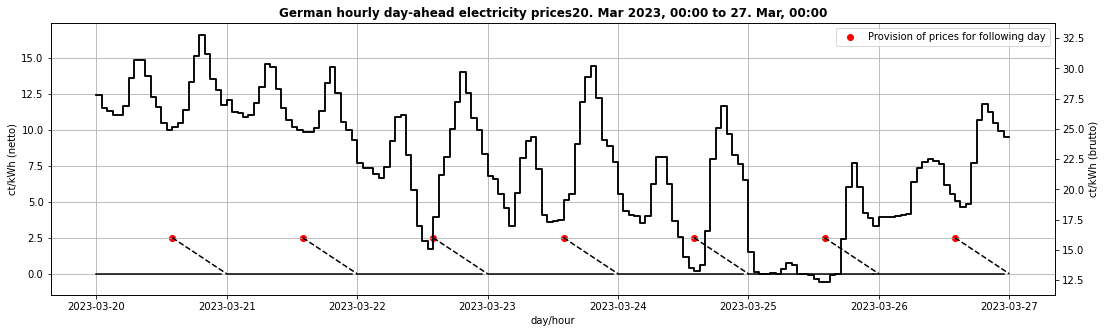

In [47]:
fig, ax1 = plot_hourly_forecast(x,np.array(y)/10, (1.19*np.array(y)/10)+13.036) # €/MWh -> ct/kWh; brutto->netto
for i in range(len(x)):
    if x[i].hour==14:
        l1=ax1.scatter(x[i], 2.5, c='red')
        ax1.plot([x[i],x[i+10]],[2.5,0], c='black', linestyle='dashed')
        ax1.plot([x[i-14],x[i+9]],[0,0], c='black')
plt.legend([l1],['Provision of prices for following day']);

### Bild 1: Preise pro Stunde für eine Woche

Diese Abbildung zeigt den zeitlichen Verlauf der stündlichen Börsenpreise pro kWh. Auf der linken Achse ist der Nettopreis, wie er an der Börse gehandelt wird, in ct/kWh aufgetragen. Auf der rechten Achse ist der Bruttopreis aufgetragen, wie er z.B. bei einem dynamischen Stromvertrag von [Tibber](https://www.tibber.com) zu zahlen ist. Auffällig ist die hohe Volatilität des Preises. Innerhalb einer Woche schwankt der Bruttopreis zwischen 12ct und 32ct. Innerhalb eines Tages um ca. 10ct. Damit wird deutlich, dass durch eine zeitliche Verschiebung des Verbrauchs eine deutliche Reduktion der Stromkosten möglich ist. An zwei Tagen geht der Nettopreis sogar gegen Null. An diesen Tagen müssen nur die Nebenkosten bezahlt werden.      
Die roten Punkte kennzeichnen den Zeitpunkt der Veröffentlichung der Strompreise. Diese werden jeweils am frühen Nachmittag des Vortages veröffentlicht und gelten dann unverändert für den Folgetag. D.h. eine intelligente Steuerung kann bereits am Vortag den Fahrplan z.B. für eine Wärmepumpe oder das Laden eines Elektroautos berechnen.

In [6]:
# fetch further data from the cloud.
x_s, y_s = get_time_sequence('4068', date_in_week) # Stromerzeugung: Photovoltaik
x_w, y_w = get_time_sequence('4067', date_in_week) # Stromerzeugung: Wind Onshore
x_o, y_o = get_time_sequence('1225', date_in_week) # Stromerzeugung: Wind Offshore

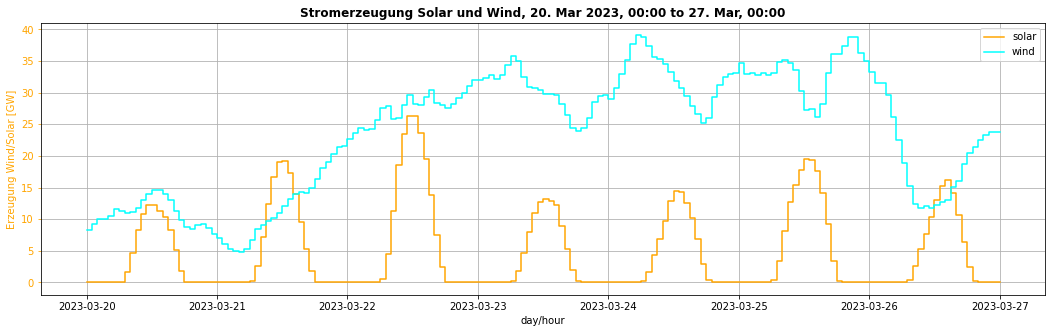

In [7]:
length  = min(len(x_s), len(x_w), len(x_o)) # make sure that the data sequences have the same length
time_1  = x_s[:length]
graph_1 = y_s[:length]/1000                 # scale it to GW
graph_2 = (y_w[:length]+y_o[:length])/1000

headline='Stromerzeugung Solar und Wind, '
colors=['orange','cyan']
y_labels=['Erzeugung Wind/Solar [GW]', None]
graph_labels = ['solar','wind']

plot_hourly_forecast(time_1, graph_1, graph_2, headline=headline, colors=colors, 
                          y_labels=y_labels, labels=graph_labels)

### Bild 2: Verlauf der Solar- und Windenergieerzeugung im Verlauf der Woche aus Bild 1.

Um den Preisverlauf in Abbildung 1 besser zu verstehen, betrachten wir in Abbildung 2 die Erzeugung aus PV- und Windkraftanlagen (Onshore und Offshore). Es gibt einen täglichen Peak der Solareinspeisung um die Mittagszeit. Dies führt in Abbildung 1 zu einem Kostenminimum um die Mittagszeit und zu zwei mehr oder weniger ausgeprägten Peaks am Morgen und am Abend. Die niedrigeren Preise in Abbildung 1 in den letzten drei Tagen sind auf die hohe Windeinspeisung und den geringeren Verbrauch am Wochenende zurückzuführen.

In [8]:
x_1, y_1 = get_time_sequence('5097', date_in_week) # Stromerzeugung: Photovoltaik+Wind
x_2, y_2 = get_time_sequence('410',  date_in_week) # Stromverbrauch

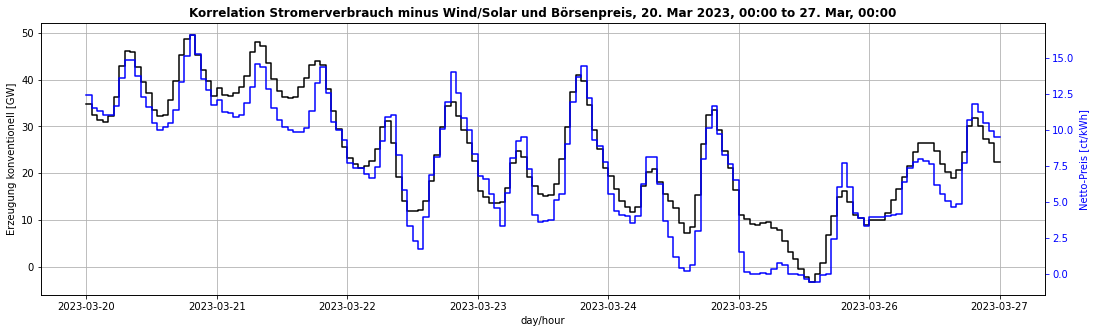

In [49]:
length = min(len(x_1), len(x_2))

time_1  = np.array(x_1)[:length]
graph_1 = (np.array(y_2)[:length]-np.array(y_1)[:length])/1000
label_1 = 'Stromverbrauch ohne PV+Wind'
graph_2 = np.array(y[:length])/10
label_2 = 'Price'
headline='Korrelation Stromerverbrauch minus Wind/Solar und Börsenpreis, '
colors=['black','blue']
y_labels=['~Erzeugung konventionell [GW]', 'Netto-Preis [ct/kWh]']

plot_hourly_forecast(time_1, graph_1, graph_2, headline=headline, colors=colors, y_labels=y_labels);

### Bild 3: Stromerverbrauch ohne Wind und PV und Börsenpreis

Bild 3 zeigt die auffallend hohe Korrelation zwischen Börsenpreis und Stromproduktion. Die blaue und die schwarze Kurve zeigen einen nahezu identischen Verlauf. Die Quellen Bioenergie und Wasserkraft sind nicht berücksichtigt, da sie eine weitgehend konstante Leistung aufweisen und die Kurve nur verschieben würden. Fazit:
- Der Börsenpreis korreliert mit der konventionellen Stromerzeugung.
- Solar- und Windenergie wirken stark dämpfend auf den Börsenpreis.

In [10]:
def function(x, a,b,c,d):
    return a*x**3 + b*x**2 + c*x + d

def function_string(coeffs): # Function to format the approximation equation in the Fig. below
    sign_1,sign_2,sign_3 = ' ',' ',' '
    if coeffs[1] >= 0:
        sign_1 = '+'
    if coeffs[2] >= 0:
        sign_2 = '+'
    if coeffs[3] >= 0:
        sign_3 = '+'
    return '${:.6f}x^3 {} {:.6f}x^2 {} {:.6f}x {} {:.6f}$'.format(coeffs[0],sign_1, coeffs[1],
                                                                  sign_2,coeffs[2], sign_3,coeffs[3])

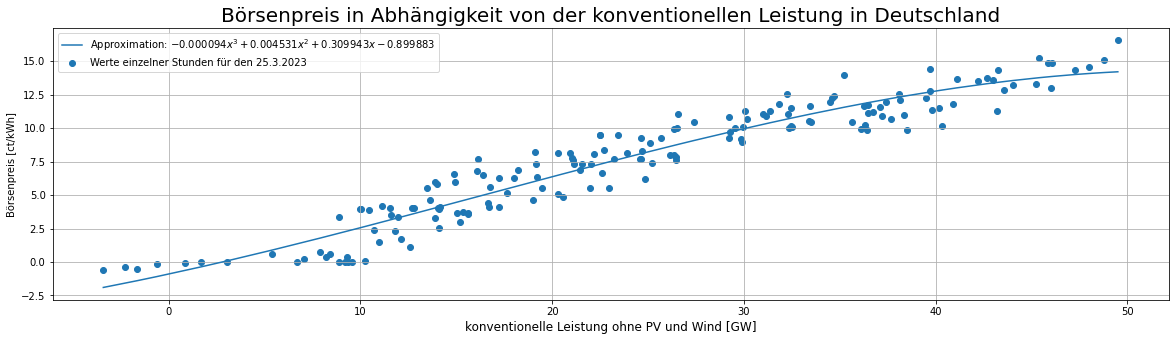

In [11]:
indexes = np.argsort(graph_1)
popt, pcov = curve_fit(function, graph_1[indexes], graph_2[indexes])

plt.rcParams["figure.figsize"] = (20,5)
label='Approximation: '+function_string(popt)
plt.plot(graph_1[indexes], function(graph_1[indexes], popt[0], popt[1],  popt[2], popt[3]), label=label)
plt.scatter(graph_1[indexes], graph_2[indexes], label='Werte einzelner Stunden für den '+ date_in_week);
plt.legend();
plt.grid()
plt.title('Börsenpreis in Abhängigkeit von der konventionellen Leistung in Deutschland', fontsize = 20)
plt.ylabel('Börsenpreis [ct/kWh]')
plt.xlabel('konventionelle Leistung ohne PV und Wind [GW]', fontsize = 12);

### Bild 4: Strompreis in Abhängigkeit von der konventionellen Erzeugungsleistung
Aus Bild 3 ist ersichtlich, dass es einen deutlichen Zusammenhang zwischen Strompreis und konventioneller Erzeugung gibt.
Trägt man die Börsenpreise über die "konventionelle Erzeugungsleistung" auf, so erhält man eine Punktewolke wie in Abbildung 4 dargestellt (ein Punkt für jede Stunde). Diese steigt mit zunehmender Leistung an und spiegelt den Merit-Order-Effekt wieder. Mit steigender Leistung werden nach und nach immer "teurere" Kraftwerke eingesetzt. Die durchgezogene Kurve ist eine Annäherung an die mittleren Kosten in Abhängigkeit von der Leistung. 


# Börsenpreis über einen längeren Zeitraum
Um den Zusammenhang in Bild 4 genauer zu untersuchen, betrachten wir längere Zeiträume. Dazu werden wieder einige Funktionen definiert.

In [50]:
def monday_of_calenderweek(year, week):
    first = datetime.date(year, 1, 1)
    base = 1 if first.isocalendar()[1] == 1 else 8
    return first + datetime.timedelta(days=base - first.isocalendar()[2] + 7 * (week - 1))

#print(monday_of_calenderweek(2023, 52).day)
#print(monday_of_calenderweek(2023, 52).month)
#print(monday_of_calenderweek(2023, 13))

In [51]:
def get_data_set_1(year, week_start, week_end):
    time_array           = np.array([])
    renewables           = np.array([])
    power_consumption    = np.array([])
    prices               = np.array([])

    #print(week_start, week_end+1)
    for day in range(week_start, week_end+1):
        #print(day)
        monday_of_week                   = monday_of_calenderweek(year, day).strftime('%d.%m.%Y')
        times_of_week, renewables_a_week = get_time_sequence('5097', monday_of_week) # Stromerz.: PV+Wind
        times_of_week, power_cons_a_week = get_time_sequence('410',  monday_of_week) # Stromverbrauch
        times_of_week, prices_a_week     = get_time_sequence('4169', monday_of_week) # Marktpreis: DE/LU
                                         # reduce the number of data from Mon. 00:00 to Sun 23:00
        length                           = max(min(len(times_of_week), len(renewables_a_week), 
                                                   len(power_cons_a_week), len(prices_a_week))-1,0)
        time_array                       = np.concatenate((time_array, times_of_week[:length]), axis=0)
        renewables                       = np.concatenate((renewables, renewables_a_week[:length]), axis=0)
        power_consumption                = np.concatenate((power_consumption, power_cons_a_week[:length]), 
                                                          axis=0)
        prices                           = np.concatenate((prices, prices_a_week[:length]), axis=0)
    return time_array, renewables, power_consumption, prices


time_array, renewables, power_consumption, prices = get_data_set_1(2023, 1, 14)
print('Hourly values from {} to {}.'.format(time_array[0], time_array[len(time_array)-1]))

Hourly values from 2023-01-02 00:00:00 to 2023-04-03 13:00:00.


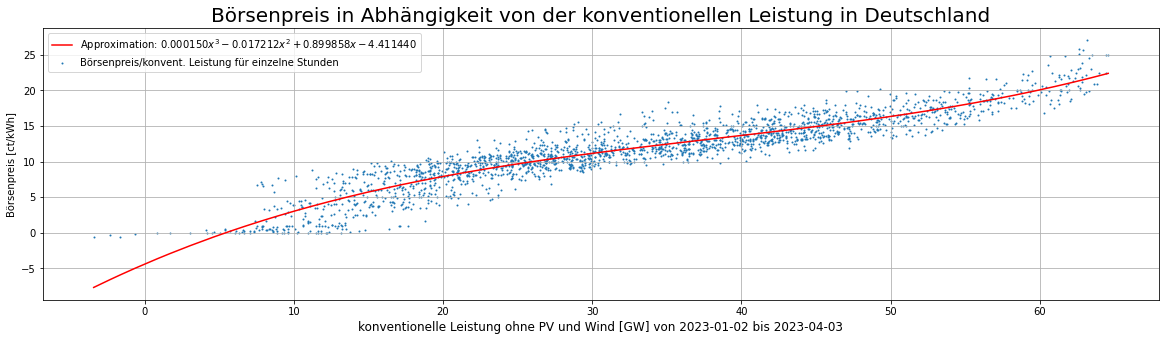

In [52]:
def plot_price_appoximation(consumption_without_wind_pv, prices_scaled): #replace prices_scaled with prices
    #consumption_without_wind_pv = (power_consumption-renewables)/1000
    #prices_scaled               = np.array(prices_scaled)/10

    indexes = np.argsort(consumption_without_wind_pv)
    popt, pcov = curve_fit(function, consumption_without_wind_pv[indexes], prices_scaled[indexes])


    plt.rcParams["figure.figsize"] = (20,5)
    label='Approximation: '+function_string(popt)
    plt.plot(consumption_without_wind_pv[indexes], 
             function(consumption_without_wind_pv[indexes], popt[0], popt[1],  popt[2], popt[3]), 
             label=label, color='red')
    plt.scatter(consumption_without_wind_pv[indexes], prices_scaled[indexes], 
                label='Börsenpreis/konvent. Leistung für einzelne Stunden', s=1);
    plt.legend();
    plt.grid()
    plt.title('Börsenpreis in Abhängigkeit von der konventionellen Leistung in Deutschland', fontsize = 20)
    plt.ylabel('Börsenpreis [ct/kWh]')
    plt.xlabel('konventionelle Leistung ohne PV und Wind [GW] von '+
               str(time_array[0])[0:10]+' bis '+str(time_array[len(time_array)-1])[:10], fontsize = 12);


plot_price_appoximation((power_consumption-renewables)/1000, prices/10)


### Bild 5: Strompreise in den Ersten Monaten 2023 in Abhängigkeit von der konvionellen Leistung

Im Vergleich zu Bild 4 liegen hier mehr Datenwerte über einen größeren Leistungsbereich vor.
Neben dem annähernd linearen Anstieg im mittleren Bereich fällt der steilere Anstieg unterhalb von 20 GW und oberhalb von 50 GW auf. Dies könnte darauf hindeuten, dass bei geringer konventioneller Nachfrage nur schwer zusätzliche Kraftwerke abgeschaltet werden können und bei hoher Nachfrage Kraftwerke mit überproportional teuren Brennstoffen zum Einsatz kommen. Auffällig ist, dass der Börsenpreis bei geringer und negativer Leistung kaum in den negativen Bereich fällt. Dies war in früheren Jahren anders, wie die folgenden Abbildungen zeigen.      
Die Grafik ist nur eine grobe Abschätzung, da viele Einflussfaktoren, wie z.B. Biomasse, Wasserkraft, Pumpspeicher, Import/Export, etc. nicht berücksichtigt sind.

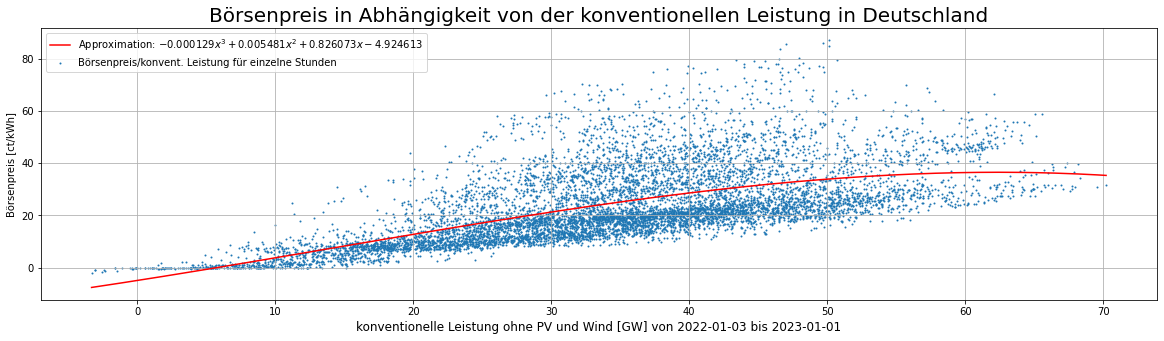

In [53]:
%matplotlib inline
time_array, renewables, power_consumption, prices = get_data_set_1(2022, 1, 52)
plot_price_appoximation((power_consumption-renewables)/1000, prices/10)


### Bild 6: Strompreise im gesamten Jahr 2022 in Abhängigkeit von der konvionellen Leistung
In Bild 6 fällt sofort auf, dass keine klare Korrelation vorhanden ist. Neben einem starken Band von Datenpunkten im unteren Bereich der "Datenwolke" sind sehr viele Outlier mit hohen Preisen (mehr als 20ct/kWh) vorhanden.

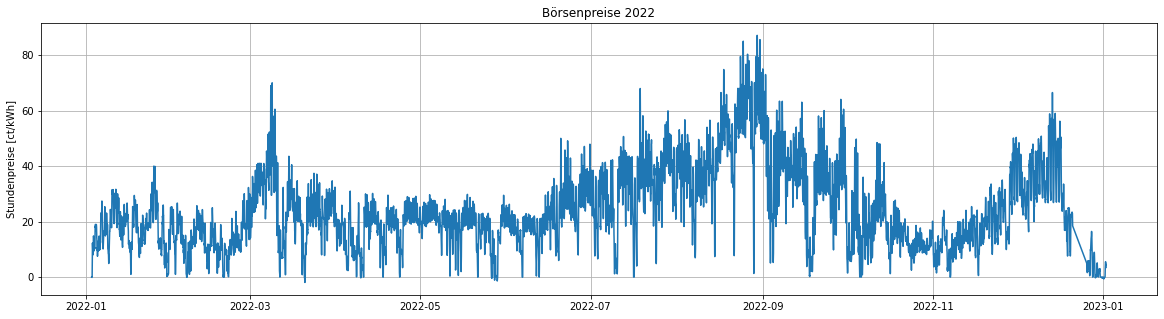

In [55]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(time_array, prices/10)
plt.ylabel('Stundenpreise [ct/kWh]')
plt.title('Börsenpreise 2022')
plt.grid()

### Bild 7: Strompreise im Jahr 2022
Trägt man den Preis über die Zeit auf, zeigt sich, dass sich über Jahr (unabhängig von der Benötigten konventionellen Erzeugung) eine Starke Fluktuation und insbesondere hohe Spitzenpreise auftreten. Diese sind durch die Krisen (Ukrainekrieg, Energiekriese) hervorgerufen und überdecken die sonstige Abhängigkeit von der Erzeugungsleistung.

In [57]:
%matplotlib inline
time_array, renewables, power_consumption, prices = get_data_set_1(2021, 1, 52)
#plot_price_appoximation((power_consumption-renewables)/1000, prices)


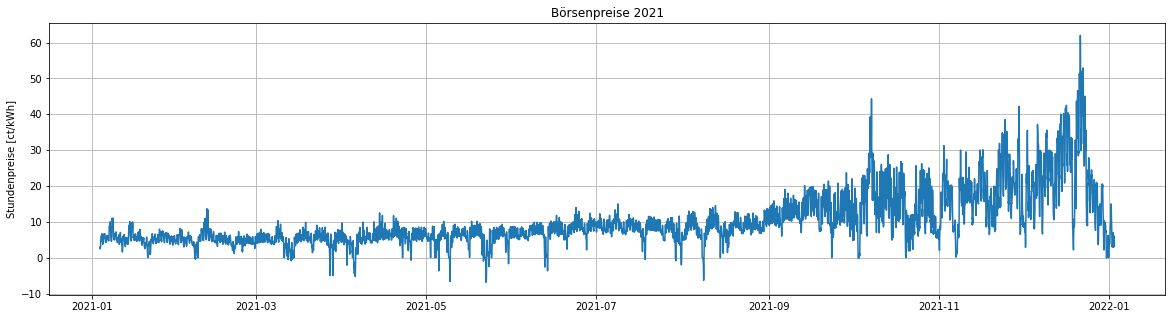

In [61]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(time_array, prices/10)
plt.ylabel('Stundenpreise [ct/kWh]')
plt.title('Börsenpreise 2021')
plt.grid()

### Bild 8: Strompreise im Jahr 2021
Bild 8 zeigt, dass bereits ca. Mitte 2021 starken Ausschläge des Strompreises begonnen haben.

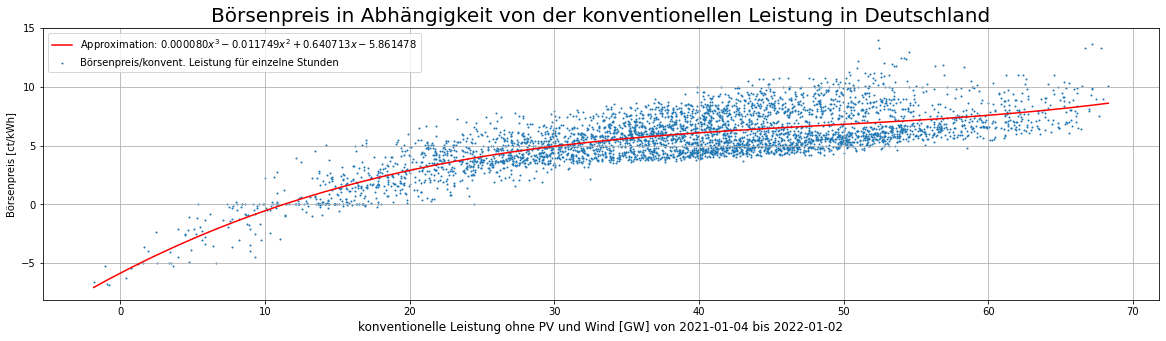

In [59]:
%matplotlib inline
limit = int(len(prices)/2)
plot_price_appoximation(((power_consumption-renewables)/1000)[:limit], prices[:limit]/10)

### Bild 9: Strompreise im ersten Halbjahr 2021 in Abhängigkeit von der konventionellen Leistung
Im ersten Halbjahr 2021 war die Situation noch einigermaßen im gewohnten 'Bereich".

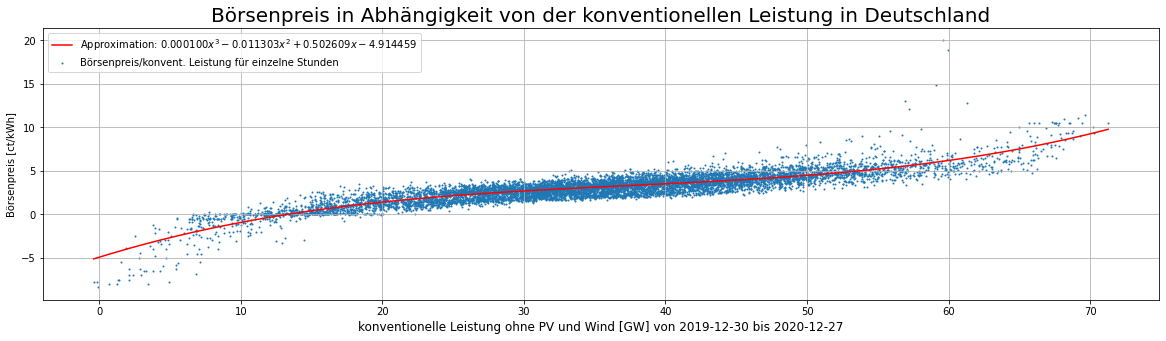

In [62]:
%matplotlib inline
time_array, renewables, power_consumption, prices = get_data_set_1(2020, 1, 52)
plot_price_appoximation((power_consumption-renewables)/1000, prices/10)

### Bild 10: Strompreise im Jahr 2020 in Abhängigkeit von der konvionellen Leistung
In 2020 ist über das gesamte jahr eine glare Abhängigkeit konventionelle Erzeugung zu Strompreis erkennbar.

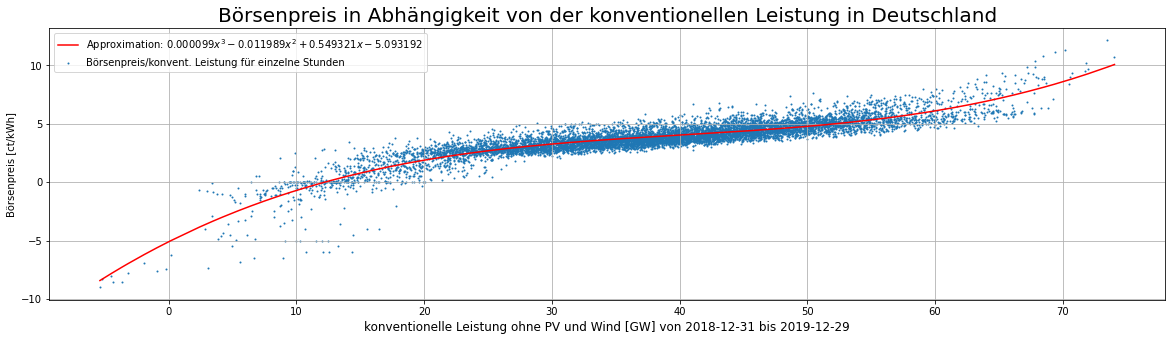

In [63]:
time_array, renewables, power_consumption, prices = get_data_set_1(2019, 1, 52)
plot_price_appoximation((power_consumption-renewables)/1000, prices/10)

### Bild 11: Strompreise 2019 in Abhängigkeit von der konventionellen Leistung
Auch 2019 zeigt einen deutlichen Zusammenhang. Zusätzlich erkennt man die deutlichen Ausschläge in den Bereich negativer Preise, siehe linker Teil des Diagramms, wo die Einspeisung aus Sonne und Wind dominiert. Diese negativen Preise nehmen über die Jahre sukzessive ab und zeigen aktuell eine starke Begrenzung bei ca. 0 ct.
# Zusammenfassung
Über die Bundesnetzagentur werden zahlreiche maschinenverarbeitbare Daten zum Strommarkt und zur Stromerzeugung bereitgestellt. Dabei werden auch stündliche Strompreise für den jeweils nächsten Tag geliefert. Diese variieren abhängig von Tag, Uhrzeit, Solar- und Windeinspeisung. 
Durch die Verlagerung des Stromverbrauchs in Zeiten niedriger Preise können deutlich Kosten eingespart werden und die Energie wird dann verbraucht, wenn ein hohes Angebot an Solar- und/oder Windstrom vorhanden ist. Damit einher geht eine Entlastung fossiler Spitzenlast-Kraftwerke und eine Reduktion des CO2-Ausstoßes.